### Description of notebook

In this notebook, I implement Deep Successor Reinforcement Learning by Tejas D. Kulkarni, Ardavan Saeedi, Simanta Gautam, Samuel J. Gershman. ([link](https://arxiv.org/abs/1606.02396))

v12 -  attempt on pong game

To do:
- include visdom for visualization

### Loading required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print("Device used: " + "GPU" if torch.cuda.is_available() else "CPU")

import gym
import math
import random
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from skimage.transform import resize

Device used: GPU


### Setting up environment

In [2]:
IMG_HEIGHT = 80
IMG_WIDTH = 80

def get_screen(env):
    k = env.render(mode='rgb_array')
    k = resize(k, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=False)
    k = torch.Tensor(k)
    k = k.permute(2,1,0).unsqueeze(0)
    k = k.to(device)
    return k

3


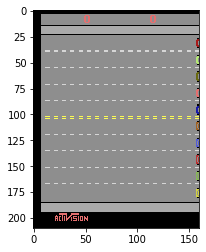

(210, 160, 3)


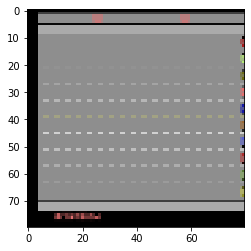

In [3]:
from gym_minigrid.envs import EmptyEnv

env_name = 'Freeway-v4'
# env_name = 'Boxing-v4'
# env_name='MiniGrid-Empty-Random-5x5-v0'
# env = EmptyEnv()
env = gym.make(env_name)
print(env.action_space.n)
# env.action_space.n = 6
env.reset()
k = env.render(mode='rgb_array')
plt.imshow(env.render(mode='rgb_array'));plt.show()
print(k.shape)
plt.imshow(resize(k, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=False))

action =  0


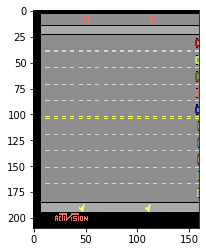

(210, 160, 3)


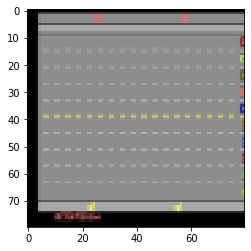

In [4]:
a = env.action_space.sample(); print('action = ', a)
env.step(a)
k = env.render(mode='rgb_array')
plt.imshow(env.render(mode='rgb_array'));plt.show()
print(k.shape)
plt.imshow(resize(k, (IMG_HEIGHT, IMG_WIDTH), anti_aliasing=True))

### Implementing neural network in torch for FA

In [5]:
PHI_SIZE = 512

class thetaNet(nn.Module):
    """Encoder for abstracting the states.
    """

    def __init__(self, h=80, w=80, outputs=PHI_SIZE):
        """Constructor for encoder
        
        Inputs: 
            h -> height of input frame
            w -> width of input frame
            outputs -> size of abstracted states
        """
        super(thetaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)

        # Computing size of linear layer
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        """
        Inputs:
            x -> image of size b x 3 x h x w
            where b is the batch size
                  h, w are the height and width (80 by default)
                  
        Outputs:
            tensor of size b x 512
        """
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)));
        return self.head(x.view(x.size(0), -1))
    
class theta2Net(nn.Module): 
    """Decoder for reconstructing the state.
    """
    def __init__(self, h=80, w=80, inputs=PHI_SIZE):
        """Constructor for the decoder
        
        Inputs: 
            h -> height of reconstructed frame
            w -> width of reconstructed frame
            inputs -> size of abstracted state space
        """
        super(theta2Net, self).__init__()
        
        # Computing size of linear layer
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        self.convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        self.convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = self.convw * self.convh * 64
        
        # Creating required layers for reconstruction
        self.linear = nn.Linear(inputs, linear_input_size)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2, output_padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=5, stride=2, output_padding=1)
    
    def forward(self, x):
        """
        Inputs:
            x -> tensor of size b x 512
            where b is the batch size
                  
        Outputs:
            tensor of size b x 3 x h x w
            (same size of the input so that MSE can be calculated)
        """
        x = F.relu(self.linear(x))
        x = x.view(x.size(0), 64, self.convh, self.convw)
        x = self.bn1(x)
        x = F.relu(self.bn2(self.deconv1(x)))
        x = F.relu(self.bn3(self.deconv2(x)))
        x = self.deconv3(x)
        return x
    
class alphaNet6(nn.Module):
    """Network that finds successor features from abstracted states
    
    This network assumes three output actions.
    """

    def __init__(self, in_size=PHI_SIZE, mid_size=256, actions=6):
        """
        Inputs:
            in_size -> size of abstracted states (int)
            mid_size -> number of nodes in pre ultimate layer (int)
        """
        super(alphaNet6, self).__init__()
        
        # Creating required layers for finding SRs
        self.head11 = nn.Linear(in_size, in_size)
        self.head12 = nn.Linear(in_size, mid_size)
        self.head13 = nn.Linear(mid_size, in_size)
        self.head21 = nn.Linear(in_size, in_size)
        self.head22 = nn.Linear(in_size, mid_size)
        self.head23 = nn.Linear(mid_size, in_size)
        self.head31 = nn.Linear(in_size, in_size)
        self.head32 = nn.Linear(in_size, mid_size)
        self.head33 = nn.Linear(mid_size, in_size)
        self.head41 = nn.Linear(in_size, in_size)
        self.head42 = nn.Linear(in_size, mid_size)
        self.head43 = nn.Linear(mid_size, in_size)
        self.head51 = nn.Linear(in_size, in_size)
        self.head52 = nn.Linear(in_size, mid_size)
        self.head53 = nn.Linear(mid_size, in_size)
        self.head61 = nn.Linear(in_size, in_size)
        self.head62 = nn.Linear(in_size, mid_size)
        self.head63 = nn.Linear(mid_size, in_size)
        self.actions = actions

    def forward(self, x):
        """
        Inputs:
            x -> b x 512
        Returns:
            Sucessor features in the tensor b x Na x 512
            (where Na is the number of actions)
        """
        x1 = self.head13(F.relu(self.head12(F.relu(self.head11(x)))))
        x2 = self.head23(F.relu(self.head22(F.relu(self.head21(x)))))
        x3 = self.head33(F.relu(self.head32(F.relu(self.head31(x)))))
        x4 = self.head43(F.relu(self.head42(F.relu(self.head41(x)))))
        x5 = self.head53(F.relu(self.head52(F.relu(self.head51(x)))))
        x6 = self.head63(F.relu(self.head62(F.relu(self.head61(x)))))
        y = torch.cat((x1, x2, x3, x4, x5, x6), 1)
        return y.view(y.size(0), self.actions, -1)
    
class alphaNet(nn.Module):
    """Network that finds successor features from abstracted states
    
    This network assumes three output actions.
    """

    def __init__(self, in_size=PHI_SIZE, mid_size=256, actions=3):
        """
        Inputs:
            in_size -> size of abstracted states (int)
            mid_size -> number of nodes in pre ultimate layer (int)
        """
        super(alphaNet, self).__init__()
        
        # Creating required layers for finding SRs
        self.head11 = nn.Linear(in_size, in_size)
        self.head12 = nn.Linear(in_size, mid_size)
        self.head13 = nn.Linear(mid_size, in_size)
        self.head21 = nn.Linear(in_size, in_size)
        self.head22 = nn.Linear(in_size, mid_size)
        self.head23 = nn.Linear(mid_size, in_size)
        self.head31 = nn.Linear(in_size, in_size)
        self.head32 = nn.Linear(in_size, mid_size)
        self.head33 = nn.Linear(mid_size, in_size)
        self.actions = actions

    def forward(self, x):
        """
        Inputs:
            x -> b x 512
        Returns:
            Sucessor features in the tensor b x Na x 512
            (where Na is the number of actions)
        """
        x1 = self.head13(F.relu(self.head12(F.relu(self.head11(x)))))
        x2 = self.head23(F.relu(self.head22(F.relu(self.head21(x)))))
        x3 = self.head33(F.relu(self.head32(F.relu(self.head31(x)))))
        y = torch.cat((x1, x2, x3), 1)
        return y.view(y.size(0), self.actions, -1)
    
class wNet(nn.Module):
    """Network that maps state abstraction to rewards
    """

    def __init__(self, in_size=PHI_SIZE):
        super(wNet, self).__init__()
        self.head = nn.Linear(in_size, 1)

    def forward(self, x):
        """
        Inputs:
            x -> b x 512 tensor
        Outputs:
            tensor of size b (CHECK: b x 1?)
        """
        return self.head(x)

### Implementing replay memory

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.ready = False

    def push(self, *args):
        """Saves a transition."""
        self.ready = True
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if(len(self.memory) < batch_size):
            return random.sample(self.memory, len(self.memory)), len(self.memory)
        return random.sample(self.memory, batch_size), batch_size
    
    def is_ready(self):
        return len(self.memory)>2

    def __len__(self):
        return len(self.memory)

### Setting up networks and memory

In [7]:
tnet = thetaNet().to(device); tnet2 = theta2Net().to(device);
anet = alphaNet(actions=env.action_space.n).to(device); wnet = wNet().to(device); 
anet_target = alphaNet(actions=env.action_space.n).to(device)
anet_target.load_state_dict(anet.state_dict()); anet_target.eval()

memory = ReplayMemory(50000)
memory_win = ReplayMemory(1000)

### Creating select action method

In [8]:
steps_done = 0
BATCH_SIZE = 1000
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 5000
TARGET_UPDATE = 30
eps_threshold = 1

def select_action(phi, w, greedy=False):
    if(greedy):
        aout = anet(phi)
        return aout.matmul(w).max(1)[1]
    global steps_done
    global eps_threshold
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            aout = anet(phi)
            return aout.matmul(w).max(1)[1] #maybe add .view(1,1)
    else:
#         import pdb; pdb.set_trace();
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

### Optimization function

In [9]:
loss = nn.MSELoss()
loss_a = nn.MSELoss()
loss_b = nn.MSELoss()
L_r_vec = []
L_m_vec = []
L_a_vec = []

tw_params = list(tnet.parameters()) + list(tnet2.parameters()) + list(wnet.parameters())
optimizer_tw = optim.Adam(tw_params, lr=50e-5)
optimizer_a = optim.Adam(anet.parameters(), lr=25e-5)

def optimize_model():
    if (not memory.is_ready()) or (not memory_win.is_ready()):
        return
    
    # Training reward and reconstruction branches
    if(np.random.rand()>0.8): # winning samples 20% times this runs
        transitions, bs = memory_win.sample(BATCH_SIZE)
        
    else: # intermediate samples
        transitions, bs = memory.sample(BATCH_SIZE)
        
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    nstate_batch = torch.cat(batch.next_state)
    action_max = anet(tnet(state_batch)).matmul(wnet.head.weight.data.view(-1,1)).max(1)[1]
    next_state_ests = anet_target(tnet(nstate_batch))[torch.arange(0, bs),action_max.squeeze(),:]
    
    L_r = F.smooth_l1_loss(reward_batch, wnet(tnet(nstate_batch)).squeeze(1))
    L_a = loss_a(state_batch, tnet2(tnet(state_batch))) + loss_b(nstate_batch, tnet2(tnet(nstate_batch)))
    L_r_vec.append(L_r.item())
    L_a_vec.append(L_a.item())
    L_ra = L_a + L_r
    optimizer_tw.zero_grad()
    L_ra.backward()
    optimizer_tw.step()
    
    
    # Training the SR branch
    transitions, bs = memory.sample(32)
    batch = Transition(*zip(*transitions))
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    nstate_batch = torch.cat(batch.next_state)
    done_batch = torch.cat(batch.done)
    
    
    # Create a non-final state mask
    non_final_mask = torch.tensor(tuple(map(lambda s: s==0,
                                          batch.done)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for en, s in enumerate(batch.next_state)
                                                if batch.done[en]==0])
    action_max = anet(tnet(non_final_next_states)).matmul(wnet.head.weight.data.view(-1,1)).max(1)[1]
    # initialize them to values we need for terminal states
    next_state_ests = tnet(nstate_batch) 
    # replace the values of non-terminal states based on update equation
    
    next_state_ests[non_final_mask] = anet_target(tnet(non_final_next_states))[torch.arange(0, non_final_mask.sum()),
                                                                               action_max.squeeze(),:]
    U_observed = anet(tnet(state_batch))[torch.arange(0, bs),action_batch.squeeze(),:]
    U_estimated = tnet(state_batch) + GAMMA * next_state_ests
    L_m = loss(U_observed, U_estimated)
    L_m_vec.append(L_m.item())
    optimizer_a.zero_grad()
    L_m.backward()
    optimizer_a.step()

### Evaluation function

In [10]:
env_test = gym.make(env_name)
def evaluate(no_seeds=10):
    r_vec = []
    for i in range(no_seeds):
        env_test.seed(i)
        env_test.reset()
        Rt = 0
        for timesteps in count():
            # choose greedy action
            action = select_action(tnet(get_screen(env_test)), wnet.head.weight.data.view(-1,1), greedy=True)
            _, R, done, _ = env_test.step(action.item())
            Rt = R + Rt
            if(done):
                r_vec.append(R)
                break
                
    return np.mean(r_vec), np.std(r_vec) 

### Main code

In [11]:
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange

In [12]:
# Initializations: Line 1
num_episodes = 50 # CHANGE
n_actions = 3
R_eps = []
ed = []; eps_vec = [];
actions = []
eval_r_mean = []; eval_r_std = []
EVAL_INTERVAL = 1000
max_ep_len = 1000

#Setting seeds
torch.manual_seed(0); np.random.seed(0)
env.seed(0)
torch.backends.cudnn.deterministic = True

In [14]:
global i_episode
for i_episode in tqdm(range(num_episodes), desc='episodes'): # Line 2
    R = 0
    if(BATCH_SIZE>2):
        BATCH_SIZE = BATCH_SIZE // 2
    
    # Initialize the environment and state: Line 3
#     env.seed(0)
    env.reset() # <TODO: random initial location>
    state = get_screen(env)
#     state = env.reset()
#     state = state2screen(state)
    for t in tqdm(range(max_ep_len), desc='steps', leave=False): # Line 4
#         print(t, action)
        
        # Find abstracted states: Line 5
        phi = tnet(state)
        
        # Select an action: Line 6
        action = select_action(phi, wnet.head.weight.data.view(-1,1))
        actions.append(action.item())
        
        # Perform an action: Line 7
        _, reward, done, _ = env.step(action.item())
        
        done = torch.tensor([done], device=device)
#         if(reward > 0):
#             reward = 1
        R = R + reward
        reward = torch.tensor([reward], device=device).float()
        next_state = get_screen(env)
        
        # Store the transition in memory: Line 8
        if(reward==0):
            memory.push(state, action, next_state, reward, done)
        else:
            memory_win.push(state, action, next_state, reward, done)
            memory.push(state, action, next_state, reward, done)  
#             print(reward)
#             ed.append(t+1)
#             R_eps.append(R)
#             eps_vec.append(eps_threshold)
#             break
            
        # Move to the next state
        state = next_state

        # Lines 9 - 11
        optimize_model() # TODO
        
        # Additional tracking
        if done:
            ed.append(t+1)
            R_eps.append(R)
            eps_vec.append(eps_threshold)
            break
            
    if i_episode % TARGET_UPDATE == 0:
        anet_target.load_state_dict(anet.state_dict())
        
    if eps_threshold < 1.1*EPS_END:
        break
        

KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(14,6))
# plt.errorbar(np.arange(len(eval_r_mean)), eval_r_mean, eval_r_std, linestyle='None', marker='^')
# plt.title('evaluation rewards as training progresses')

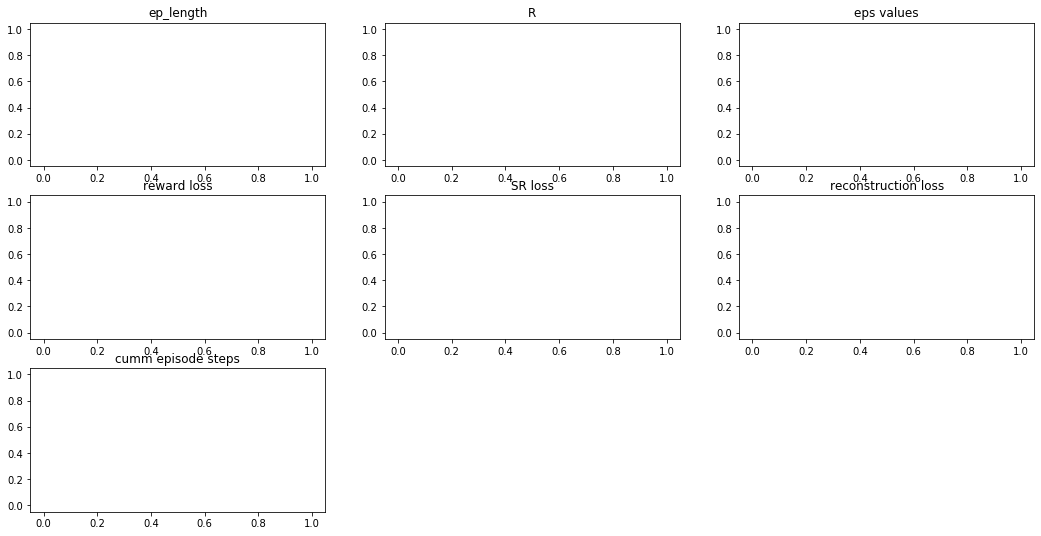

size of memories:  10325 0


In [15]:
def visualize_results():
    plt.figure(figsize=(18,9))
    plt.subplot(3,3,1); plt.plot(ed); plt.title('ep_length');
    plt.subplot(3,3,2); plt.plot(R_eps); plt.title('R'); 
    plt.subplot(3,3,3); plt.plot(eps_vec); plt.title('eps values'); 
    plt.subplot(3,3,4); plt.plot(L_r_vec[:]); plt.title('reward loss'); 
    plt.subplot(3,3,5); plt.plot(L_m_vec[:]); plt.title('SR loss'); 
    plt.subplot(3,3,6); plt.plot(L_a_vec[:]); plt.title('reconstruction loss'); 
    plt.subplot(3,3,7); plt.plot(np.cumsum(ed)); plt.title('cumm episode steps'); plt.show()

visualize_results()
print('size of memories: ', len(memory), len(memory_win))

In [ ]:
plt.figure(figsize=(18,6))
plt.plot(actions); plt.title('sanity check for actions')

### Sanity checks

In [ ]:

def visualize_samples_from_memory(memory, batchsize=4):
    k = memory.sample(4)
    plt.figure(figsize=(6,6))
    for i in range(4):
        print(i)
        plt.subplot(2,2,i+1)
        plt.imshow(k[0][i].next_state.cpu().squeeze(0).permute(1,2,0).numpy())
        plt.title('R = {}'.format(k[0][i].reward.cpu().numpy()[0]))
    plt.show()
    
visualize_samples_from_memory(memory)
visualize_samples_from_memory(memory_win)

In [ ]:
def find_qvalues(i):
    state_matrix = torch.load('state_matrix_3x3.pt')
#     print(anet(tnet(state_matrix[i,:,:,:].unsqueeze(0))).shape)
    print(anet(tnet(state_matrix[i,:,:,:].unsqueeze(0))).squeeze(0).matmul(wnet.head.weight.data.squeeze(0)))

find_qvalues(23)

In [ ]:
def sanity_check():
#     env.seed(0)
    env.reset()
    eps_threshold = 1
    iterations = 15
    plt.figure(figsize=(15,10), dpi=200)
    R = 0
    for i in range(iterations):
        plt.subplot(5,6,2*i+1)
        plt.imshow(env.render(mode='rgb_array')); 
        plt.subplot(5,6,2*i+2)
        plt.imshow(tnet2(tnet(get_screen(env))).cpu().squeeze(0).permute(1,2,0).detach().numpy());
        state = get_screen(env)
        plt.title('R = {0:.2f}, i = {1:.0f}'.format(wnet(tnet(state)).detach().cpu().numpy()[0,0], i))
        action = select_action(tnet(state), wnet.head.weight.data.view(-1,1), greedy=True)
#         action = np.random.randint(low=0, high=3)
        print('iteration: {}, action: {}, R: {}, i: {}'.format(i, action.item(), R, i))
        print(wnet(tnet(state)))
#         print(anet(tnet(state)).matmul(wnet.head.weight.data.view(-1,1)).detach().cpu().numpy())
        _, R, done, _ = env.step(action)
        if(done):
            print('SOLVED!')
            break
    plt.show()
sanity_check()

In [ ]:
a, b = evaluate(10)
print(a)

In [ ]:
plt.imshow(env.render(mode='rgb_array'))

In [ ]:
def save_models(label="tmp"):
    torch.save(tnet.state_dict(), label+"tnet"+".pt")
    torch.save(tnet2.state_dict(), label+"tnet2"+".pt")
    torch.save(anet.state_dict(), label+"anet"+".pt")
    torch.save(wnet.state_dict(), label+"wnet"+".pt")
    
# save_models()

In [ ]:
def reward_sanity_check():
    state_matrix = torch.load('state_matrix_3x3.pt')
    reward_est = wnet(tnet(state_matrix)).squeeze(1)
    reward_est = reward_est.detach().cpu().numpy()
    error_0 = np.mean(np.abs(reward_est[:32]-np.zeros(32)))
    error_1 = np.mean(np.abs(reward_est[34:]-np.ones(2)))
    print('0-reward error: {0:2.3f}, 1-reward error: {1:2.3f}'.format(error_0, error_1))
    print('reward estimates: ', reward_est)
    
reward_sanity_check()

In [ ]:
# warnings.simplefilter("once")
def reconstruction_sanity_check():
    state_matrix = torch.load('state_matrix_3x3.pt')
    state_r = tnet2(tnet(state_matrix))
    plt.figure(figsize=(18,18), dpi=100)
    for i in range(36):
        plt.subplot(12,8,2*i+1)
        plt.imshow(state_matrix.detach().cpu()[i,:,:,:].squeeze(0).permute(1,2,0).numpy())
        plt.subplot(12,8,2*i+2)
        plt.imshow(state_r.detach().cpu()[i,:,:,:].squeeze(0).permute(1,2,0).numpy())
    plt.show()
    
reconstruction_sanity_check()

In [ ]:

def SR_sanity_check(): # this needs to fail, would be correct for incorrect implementations
    
    state_matrix = torch.load('state_matrix_3x3.pt')
    
    phi = tnet(state_matrix)
    exp1 = GAMMA * phi[35,:].detach().cpu().numpy()
    exp2 = GAMMA * phi[34,:].detach().cpu().numpy()
    
    M = anet(tnet(state_matrix))
    est1 = M[23,2,:].detach().cpu().numpy()
    est2 = M[30,2,:].detach().cpu().numpy()
    
    plt.figure(figsize=(18,6))
    plt.plot(exp1);
    plt.plot(est1); plt.show()
    plt.figure(figsize=(18,6))
    plt.plot(exp2);
    plt.plot(est2); plt.show()
    
    print('error1: {}, error2: {}'.format(np.mean(np.abs(exp1-est1)),np.mean(np.abs(exp2-est2))))
    
    pass

SR_sanity_check()